In [ ]:
# !pip install scipy

In [2]:
from scipy.io import loadmat

loaded_dataset = loadmat("dataset_liver_bmodes_steatosis_assessment_IJCARS.mat")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

# Display one scan

In [ ]:
# Display the 1 person's scan
images = loaded_dataset["data"]["images"][0][0]

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap="gray")
    ax.axis("off")
    ax.text(
        0.5,
        -0.15,
        f"Steatosis: {loaded_dataset['data']['class'][0][0][0][0]}",
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.25,
        f"Fat: {loaded_dataset['data']['fat'][0][0][0][0]}%",
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )

plt.show()

# Display sample ultrasound scans

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    images = loaded_dataset["data"]["images"][0][i]

    ax.imshow(images[0], cmap="gray")
    ax.axis("off")
    ax.text(
        0.5,
        -0.1,
        f"Steatosis: {loaded_dataset['data']['class'][0][i][0][0]}, fat%: {loaded_dataset['data']['fat'][0][i][0][0]}",
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )

plt.show()

### Display a random image

In [ ]:
image = loaded_dataset["data"]["images"][0][24][0]
image = image.astype("uint8")

scaled_image = (image / np.max(image)) * 255
scaled_image = scaled_image.astype(np.uint8)

In [ ]:
# Display the image
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

## Histograms - scaled and unscaled

In [ ]:
non_zero_values = image.flatten()[image.flatten() != 0]

pd.Series(non_zero_values).plot(kind="hist", bins=100, title="Image pixel distribution")

In [ ]:
non_zero_values = scaled_image.flatten()[scaled_image.flatten() != 0]
pd.Series(non_zero_values).plot(
    kind="hist", bins=100, title="Scaled image pixel distribution"
)

In [4]:
# performs worse than enhancer_img function when checked with cross validation

def enhance_image(image):

    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply histogram equalization to enhance contrast
    enhanced_image = cv2.equalizeHist(scaled_image)

    # Apply Gaussian blur to reduce noise
    enhanced_image = cv2.GaussianBlur(enhanced_image, (5, 5), 0)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    normalized_image = cv2.normalize(
        sharpened_image,
        None,
        alpha=0,
        beta=1,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    return normalized_image

In [5]:
def enhancer_image(image):
    image = np.uint8(image)
    scaled_image = (image / np.max(image)) * 255
    scaled_image = scaled_image.astype(np.uint8)

    # Apply adaptive histogram equalization (CLAHE) to enhance local contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(scaled_image.astype(np.uint8))

    # Apply bilateral filtering for noise reduction while preserving edges
    enhanced_image = cv2.bilateralFilter(enhanced_image, 15, 50, 50)

    # Apply sharpening using the Laplacian filter
    laplacian = cv2.Laplacian(enhanced_image, cv2.CV_64F)
    sharpened_image = np.uint8(np.clip(enhanced_image - 0.5 * laplacian, 0, 255))
    normalized_image = cv2.normalize(
        sharpened_image,
        None,
        alpha=0,
        beta=1,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )

    return normalized_image

In [ ]:
def show_img(label, image):
    # image = image.astype(np.uint8)

    cv2.imshow(label, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
enhanced_img1 = enhance_image(image)
enhanced_img2 = enhancer_image(scaled_image)

plt.figure(figsize=(8, 6))

# Plot first image
plt.subplot(2, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original")
plt.axis("off")

# Plot second image
plt.subplot(2, 2, 2)
plt.imshow(scaled_image, cmap="gray")
plt.title("Scaled")
plt.axis("off")

# Plot third image
plt.subplot(2, 2, 3)
plt.imshow(enhanced_img2, cmap="gray")
plt.title("More enhanced(?)")
plt.axis("off")

# Plot fourth image
plt.subplot(2, 2, 4)
plt.imshow(enhanced_img1, cmap="gray")
plt.title("Enhanced")
plt.axis("off")

plt.tight_layout()
plt.show()

## Full fledged code:

### Making dataframe, saving original, enhanced and roi images into directories

In [41]:
data = loaded_dataset["data"]
data_records = {"id": [], "fat": [], "class": [], "images": []}

for record in range(55):
    id_ = data["id"][0][record][0][0]
    fat = data["fat"][0][record][0][0]
    cat = data["class"][0][record][0][0]
    imgs = data["images"][0][record]

    for index, im in enumerate(imgs):
        filename = f"{id_}_{cat}_{fat}_{index}.jpg"
        enh_im = enhance_image(im.astype(np.uint8))
        enh_im1 = enhancer_image(im.astype(np.uint8))

        # cropping the image for region of interest
        roi_im = enh_im1[120:350, 125:420]
        roi_im = roi_im.astype(np.uint8)

        data_records["id"].append(id_)
        data_records["fat"].append(fat)
        data_records["class"].append(cat)
        data_records["images"].append(roi_im)

        # to save images:
        # plt.imsave(f"og/{filename}", im.astype(np.uint8),cmap="grey" )
        # plt.imsave(f"enh/{filename}", enh_im, cmap="grey" )
        # plt.imsave(f"roi/{filename}", roi_im, cmap="grey" )

df = pd.DataFrame(data_records)

In [42]:
df

,id,fat,class,images
0,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1,3,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...
545,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
546,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
547,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
548,55,20,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [43]:
df["images"][0].shape

(230, 295)

In [111]:
from skimage.feature import graycomatrix, graycoprops


# Define function to compute GLCM features for a single image
def compute_glcm_features(image):
    distances = [1, 2, 3]  # Define distances for GLCM computation
    angles = [
        0,
        np.pi / 4,
        np.pi / 2,
        3 * np.pi / 4,
    ]  # Define angles for GLCM computation
    glcm = graycomatrix(
        image, distances=distances, angles=angles, symmetric=True, normed=True
    )

    # Compute GLCM properties
    contrast = graycoprops(glcm, "contrast").ravel()
    energy = graycoprops(glcm, "energy").ravel()
    homogeneity = graycoprops(glcm, "homogeneity").ravel()
    correlation = graycoprops(glcm, "correlation").ravel()

    # Concatenate GLCM features
    glcm_features = np.concatenate([contrast, energy, homogeneity, correlation])
    return glcm_features

In [112]:
import numpy as np

images = df["images"].values

# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image) for image in images]

# Concatenate GLCM features into a feature matrix
feature_matrix = np.array(glcm_features)

In [113]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Preprocess the feature matrix (scaling)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

# Apply PCA for dimensionality reduction
num_components = 10  # Choose the number of principal components
pca = PCA(n_components=num_components)
pca_features = pca.fit_transform(scaled_features)

In [114]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [7.54429610e-01 1.98690538e-01 2.00738278e-02 1.51954106e-02
 4.81342001e-03 1.93242329e-03 1.63288324e-03 1.27462337e-03
 9.05226561e-04 4.52046093e-04]


In [119]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# X = np.vstack(df['images'].apply(lambda x: x.flatten()))
y = df[["class"]]
# Step 1: Split Data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    feature_matrix, y, test_size=0.2, random_state=42
)

In [123]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

# Step 2: Feature Transformation (PCA)
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# Convert column vector y to a 1D array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [124]:
# Step 3: Train SVM classifier
clf = SVC()
clf.fit(X_train_pca, y_train)


# Step 4: Predict and Evaluate
y_pred = clf.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7363636363636363


pca with n
|n|accuracy|
|---|---|
|300|0.772727272|
|200|0.772727272|
|100-120 |0.7818181|
|80-95|0.772727272|


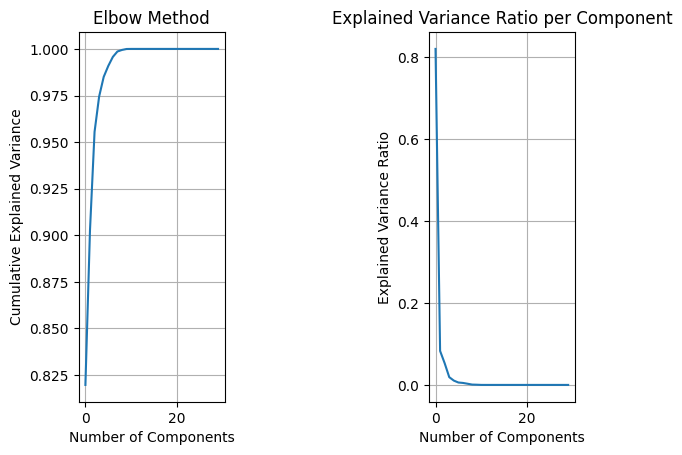

In [122]:
# Plot first image
plt.subplot(1, 3, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Elbow Method")
plt.grid(True)

# Method 2: Cumulative Variance
plt.subplot(1, 3, 3)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Ratio per Component")
plt.grid(True)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score

# # Initialize arrays to store the number of components and corresponding accuracies
# n_components_list = []
# accuracy_list = []
# # Convert column vector y to a 1D array
# y_train_ravel = np.ravel(y_train)
# y_test_ravel = np.ravel(y_test)
# clf = SVC()

# # Loop through different numbers of components
# for n_components in range(80, 300, 10):

#     # Step 2: Feature Transformation (PCA)
#     pca = PCA(n_components=n_components)
#     X_train_pca = pca.fit_transform(X_train)
#     X_test_pca = pca.transform(X_test)

#     # Step 3: Train SVM classifier
#     clf.fit(X_train_pca, y_train_ravel)

#     # Step 4: Predict and Evaluate
#     y_pred = clf.predict(X_test_pca)
#     accuracy = accuracy_score(y_test_ravel, y_pred)

#     # Store results
#     n_components_list.append(n_components)
#     accuracy_list.append(accuracy)
#     print(n_components, accuracy)

# # Plot n vs. accuracy graph
# plt.figure(figsize=(10, 6))
# plt.plot(n_components_list, accuracy_list, marker='o', linestyle='-')
# plt.title('Number of PCA Components vs. Accuracy')
# plt.xlabel('Number of PCA Components')
# plt.ylabel('Accuracy')
# plt.grid(True)
# plt.show()

In [142]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the number of folds for cross-validation
num_folds = 7

# Initialize a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(feature_matrix)
feature_matrix = scaled_features
# Initialize a PCA object
pca = PCA(n_components=11)

# Initialize a Support Vector Machine classifier
clf = SVC()

# Initialize an array to store accuracy scores
accuracy_scores = []
y = df[["class"]]

# Perform cross-validation
for train_index, test_index in kf.split(feature_matrix):
    X_train, X_test = feature_matrix[train_index], feature_matrix[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Calculate the mean accuracy score across all folds
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

Mean Accuracy: 0.7655909491352528


c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LWARRIER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py

In [143]:
mean_accuracy, accuracy_scores

(0.7655909491352528,
 [0.7341772151898734,
  0.7721518987341772,
  0.7215189873417721,
  0.759493670886076,
  0.7692307692307693,
  0.8205128205128205,
  0.782051282051282])

After 5-cross-validation, accuracy went from Accuracy: 0.7363636363636363 to 0.78, for n=10
- Added standard scaler: 0.76181 😒

7-fold cross-val: 0.765590 without scalers

In [97]:
import pickle

with open("svm_model.pkl", "wb") as f:
    pickle.dump(clf, f)

In [107]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib  # for model persistence


import numpy as np

images = df["images"].values

# Compute GLCM features for each image
glcm_features = [compute_glcm_features(image) for image in images]

# Concatenate GLCM features into a feature matrix
X = np.array(glcm_features)

y = df["class"]  # Target variable

Mean Accuracy: 0.7454545454545455


['svm_model.pkl']

In [110]:
# Initialize PCA and SVM classifier
pca = PCA(n_components=40)
clf = SVC()

# Initialize an array to store accuracy scores
accuracy_scores = []

# Define the number of folds for cross-validation
num_folds = 5

# Initialize a KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Apply PCA to the training and test data
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Train the classifier
    clf.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_pca)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)

# Optionally, save the trained model
joblib.dump(clf, "svm_model.pkl")

Mean Accuracy: 0.78


['svm_model.pkl']